In [2]:
%matplotlib inline
import numpy as np
from onezone.analysis import analysis_tools as atools
import matplotlib.pyplot as plt

from astropy import units as u
from collections import OrderedDict
from galaxy_analysis.analysis import Galaxy 

/home/aemerick/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/aemerick/code/galaxy_analysis/particle_analysis/IMF.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/aemerick/anaconda2/lib/python2.7/sit

/home/aemerick/code/galaxy_analysis/particle_analysis/sn_rate.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", li

/home/aemerick/code/galaxy_analysis/plot/plot_styles.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/aemerick/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aemerick/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, i

In [21]:


class OnezoneAbundances:
    
    def __init__(self, filename):
        
        self.filename  = filename
        self.data     = np.genfromtxt(self.filename,names=True)
        
        
        self.elements  = [x for x in np.array(self.data.dtype.names[7:])]
        
        self.retention_factors = OrderedDict()
        for e in self.elements:
            self.retention_factors[e] = 1.0
        
        self.current_time = None
        
        return
    
    def abundance_ratio(self, e1, e2, mask = None, filtered_data = True):
        
        if filtered_data:
            _data = self.filtered_data
        else:
            _data = lambda x : self.data[x]
        
        x1 = (_data(e1) * _data('M') * u.Msun).to('g').value # mass in solar
        x2 = (_data(e2) * _data('M') * u.Msun).to('g').value # mass in solar

        select = (x1 > 0.0)*(x2 > 0.0)
        
        x1 = x1[select]
        x2 = x2[select]
        
        result = np.zeros(np.size(x1))
        for i in np.arange(np.size(x1)):
            result[i] = atools.normalize_abundance_ratio( (e1,x1[i]), 
                                                          (e2,x2[i]), input_type = 'mass')
        
        
        return result
    
    def filtered_data(self, key):
        
        select = np.array([True]*np.size(self.data['M']))
        
        if not (self.current_time is None):
            formation_time = (self.data['t']*u.Myr).value
            death_time     = ((self.data['t']*u.Myr + self.data['lifetime']*u.s).to("Myr")).value
            
            select = (self.current_time > formation_time)*(self.current_time<death_time)
            
        vals = self.data[key][select]
        
        if key in self.elements:
            
            vals = vals * self.retention_factors[key]
        
        return vals

In [15]:
AGB_retention = 0.25
metal_retention = 0.05

gal = Galaxy('DD0871')

all_data = [None]*28
for i in np.arange(28):
    datafile = "run%0004i_abundances.dat"%(i)
    all_data[i] = OnezoneAbundances(datafile)
    
    for e in all_data[i].elements:
        all_data[i].retention_factors[e] = metal_retention
        
    all_data[i].retention_factors['H']  = 0.5
    all_data[i].retention_factors['He'] = 0.5
    all_data[i].retention_factors['Ba'] = AGB_retention
    all_data[i].retention_factors['N']  = AGB_retention
    


Parsing Hierarchy : 100%|██████████| 1227/1227 [00:00<00:00, 41271.33it/s]


(-3, 3)

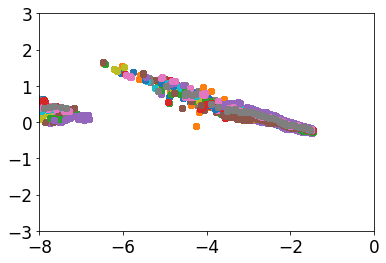

In [16]:
fig, ax = plt.subplots()


for data in all_data:
    y = data.abundance_ratio('Mg','Fe', filtered_data = False)
    x = data.abundance_ratio('Fe','H', filtered_data=False)
    ax.scatter(x,y)
    
ax.set_xlim(-8,0)
ax.set_ylim(-3,3)

Mg
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
H
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Mg
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H

['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
H
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Mg
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 

['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
H
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Mg
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
H
['H', '

(-3, 3)

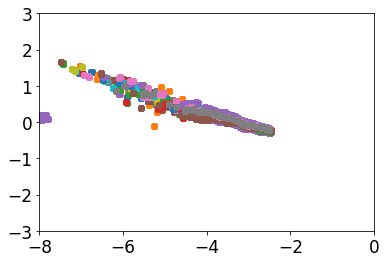

In [20]:
fig, ax = plt.subplots()


for data in all_data:
    y = data.abundance_ratio('Mg','Fe', filtered_data = True)
    x = data.abundance_ratio('Fe','H', filtered_data=True)
    ax.scatter(x,y)
    
ax.set_xlim(-8,0)
ax.set_ylim(-3,3)

Ba
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
H
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Ba
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H

['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
H
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Ba
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 

['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
H
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Ba
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
Fe
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
M
['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Ca', 'Mn', 'Fe', 'Ni', 'As', 'Sr', 'Y', 'Ba']
H
['H', '

(-3, 3)

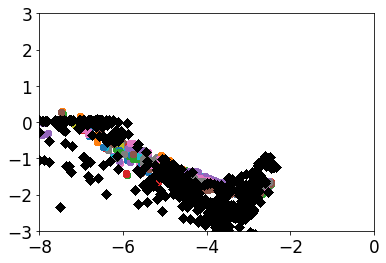

In [18]:
fig, ax = plt.subplots()


for data in all_data:
    y = data.abundance_ratio('Ba','Fe',filtered_data=True)
    x = data.abundance_ratio('Fe','H',filtered_data=True)
    ax.scatter(x,y)
    
ax.scatter(gal.df[('io','particle_Fe_over_H')].value, 
           gal.df[('io','particle_Ba_over_Fe')].value, color = 'black', marker = 'D')
ax.set_xlim(-8,0)
ax.set_ylim(-3,3)

(-3, 3)

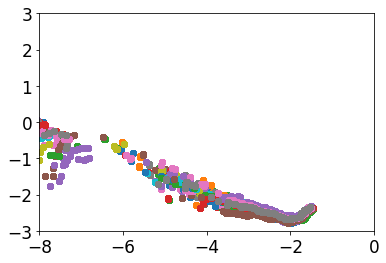

In [19]:
fig, ax = plt.subplots()


for data in all_data:
    y = data.abundance_ratio('Ba','Fe',filtered_data=False)
    x = data.abundance_ratio('Fe','H', filtered_data=False)
    ax.scatter(x,y)
ax.set_xlim(-8,0)
ax.set_ylim(-3,3)